# Comparison the AM geometric opacity with PieMieScatt 

We import `pdb` with `MgSiO3` to use the refractive index.

In [1]:
from exojax.database.pardb  import PdbCloud
miedir = "/home/kawahara/exojax/documents/tutorials/.database/particulates/virga"
#miedir = "/home/exoplanet01/exojax/documents/tutorials/.database/particulates/virga"
pdb = PdbCloud("MgSiO3", path=miedir)


/home/kawahara/exojax/documents/tutorials/.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  /home/kawahara/exojax/documents/tutorials/.database/particulates/virga/MgSiO3.refrind
Miegrid file exists: /home/kawahara/exojax/documents/tutorials/.database/particulates/virga/miegrid_lognorm_MgSiO3.mg.npz


`pdb` has the information of refractive index in `pdb.refraction_index` and `pdb.refraction_index_wavelength_nm`.
These values were taken from `VIRGA`.

Notice the refactive index has the form of $m = n + ik$.

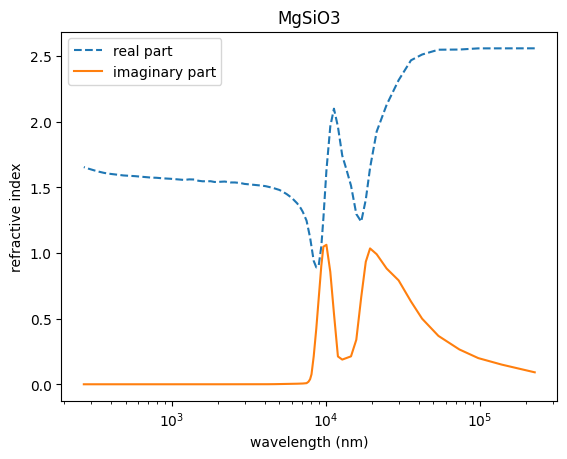

In [2]:
m = pdb.refraction_index
mwav = pdb.refraction_index_wavelength_nm

import matplotlib.pyplot as plt
plt.plot(mwav,m.real, label="real part", ls="dashed")
plt.plot(mwav,m.imag, label="imaginary part")
plt.legend()
plt.xscale("log")
plt.xlabel("wavelength (nm)")
plt.ylabel("refractive index")
plt.title("MgSiO3")
plt.savefig("mgsio3_refractive_index.png")
#plt.savefig("mgsio3_refractive_index.pdf")
plt.show()

Let's compute the opacity of the condensate for the inicident light of 2 $\mu\mathrm{m}$.

In [3]:
imie = 195
print("Incident light: " ,mwav[imie],"nm = ", mwav[imie]*1.e-3,"um")

Incident light:  268.0 nm =  0.268 um


In [4]:
rg_um = 0.05  # 0.1um = 100nm
sigmag = 2.0
cm2um = 1.0e4
cm2nm = 1.0e7

rg = rg_um / cm2um  # in cgs
rg_nm = rg * cm2nm

N0 = 1.0 # cm-3

In [5]:
from PyMieScatt import MieQ
MieQ(m[imie], mwav[imie], 2.0 * rg_nm, asDict=True)

{'Qext': 0.6246146481677305,
 'Qsca': 0.6222127380166314,
 'Qabs': 0.0024019101510991403,
 'g': 0.31392139184771023,
 'Qpr': 0.4292887594241749,
 'Qback': 0.3552936962793397,
 'Qratio': 0.5710164298658941}

In [6]:
from exojax.special.lognormal import cubeweighted_mean
rmean = cubeweighted_mean(rg, sigmag)
print(rmean*cm2nm)

268.7035


`PyMieScatt.Mie_Lognormal` can be used to compute the extinction coefficient [Mm-1] etc.
Note that the integration range lower - upper [nm] is very important. Be sure if the range is sufficient to cover the main body of the lognormal distribution 

In [7]:
# from PyMieScatt import Mie_Lognormal
from exojax.database.mie import mie_lognormal_pymiescatt
from exojax.database.mie import auto_rgrid

rgrid = auto_rgrid(rg_nm, sigmag)
coeff = mie_lognormal_pymiescatt(
    m[imie], mwav[imie], sigmag, rg_nm, N0, rgrid
)  # geoMean is a diameter in PyMieScatt

In [8]:
coeff #Bext, Bsca, Babs, bigG, Bpr, Bback, Bratio

(0.056542985376912956,
 0.0562450133928908,
 0.00029797198402215647,
 0.6040582321868927,
 0.022567722017475235,
 0.07088795617178653,
 0.029948661060947998)

Do not forget the unit of `Bext`, `Bsca`, and `Babs` is $\mathrm{Mm}^{-1}$ i.e. the inverse of mega meter. To convert the values in cgs ($\mathrm{cm^{-1}}$), just multiply $10^{-8}$.

In [9]:
beta_ext = coeff[0]*1.e-8 #Mm-1 to cm-1 

Computes the optical depth for L = 10 km and $n = 10^7 \mathrm{cm^{-3}}$ 

In [10]:
from exojax.atm.amclouds import geometric_radius
rgeo = geometric_radius(rg, sigmag)

Assuming the large size limit ($Q_e = 2$), we estimate the extinction coefficient from the geometric radius. 

In [11]:
import jax.numpy as jnp
Qe = 2 # large size limit
Qe*jnp.pi*rgeo**2 

Array(4.106162e-10, dtype=float32, weak_type=True)

This is close to the extinction coefficient computed using `PyMieScatt`. 

In [12]:
beta_ext 

5.654298537691296e-10